# Sentiment Analysis 🤗

### We are going to take a look at a dataset that has real amazon reviews and perform sentiment analysis on it where we look at the actual text of the review and use machine learning to identify based on the text if the sentiment is good,bad,neutral.

### We will use nltk for the natural langauge processing and vader as a bag of words aprroach to see how many times certain words appear per review and go from there.

### The second model we build will use a RoBERTa pretrained model and huggingface pipeline. 

In [81]:
import pandas as pd 
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
plt.style.use("ggplot")
import nltk 

In [2]:
conn = sqlite3.Connection("database.sqlite") # create a connection to the database from sql

pd.read_sql("""
SELECT *
FROM sqlite_master
""",conn)

,type,name,tbl_name,rootpage,sql
0,table,Reviews,Reviews,2,CREATE TABLE Reviews (\n Id INTEGER PRIMARY...


### All the amazon reviews are in the table called reviews so lets access that

In [3]:
df = pd.read_sql("""
SELECT *
FROM Reviews
""",conn)

conn.close() # making sure to close the connection when we are done using the database

df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


### There seems to be 568454 rows so for analysis lets just use 500 rows initially 

In [4]:
df = df.head(500)
df 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
495,496,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
496,497,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
497,498,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
498,499,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."


## Lets check the skew of the reviews based on how many stars a review got

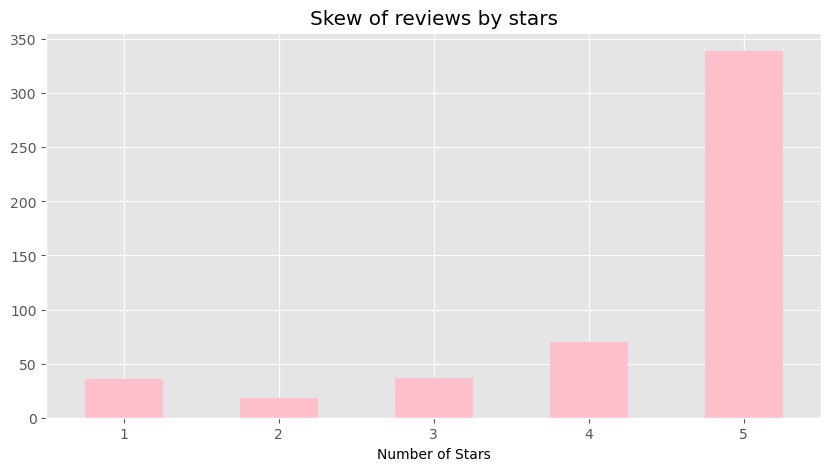

In [5]:
ax = df["Score"].value_counts().sort_index().plot(kind="bar",
                                                 title="Skew of reviews by stars",
                                                 figsize=(10,5),
                                                 color="pink")

ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_xlabel("Number of Stars");

## Lets move onto use nltk to do some natural language processing

In [6]:
example = df["Text"][20]
example #Seems like the review has postive sentiment lets seem if the machine learning model can figure 
# this out

"My husband is a Twizzlers addict.  We've bought these many times from Amazon because we're government employees living overseas and can't get them in the country we are assigned to.  They've always been fresh and tasty, packed well and arrive in a timely manner."

In [7]:
tokens = nltk.word_tokenize(example) #breaks down a sentence into it's tokens(words, grammatical terms)
tokens[:10]

['My', 'husband', 'is', 'a', 'Twizzlers', 'addict', '.', 'We', "'ve", 'bought']

In [8]:
tagged = nltk.pos_tag(tokens)
tagged[:10]
# Tells us what the words are in english grammar like NNP is a singular proper noun 
# https://www.guru99.com/pos-tagging-chunking-nltk.html tells us what the abreviations mean

[('My', 'PRP$'),
 ('husband', 'NN'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('Twizzlers', 'NNP'),
 ('addict', 'NN'),
 ('.', '.'),
 ('We', 'PRP'),
 ("'ve", 'VBP'),
 ('bought', 'VBN')]

In [9]:
chunked = nltk.chunk.ne_chunk(tagged)
chunked.pprint() # was able to chunk the words into a sentence and even figure out the Amazon is a company

(S
  My/PRP$
  husband/NN
  is/VBZ
  a/DT
  Twizzlers/NNP
  addict/NN
  ./.
  We/PRP
  've/VBP
  bought/VBN
  these/DT
  many/JJ
  times/NNS
  from/IN
  (GPE Amazon/NNP)
  because/IN
  we/PRP
  're/VBP
  government/NN
  employees/NNS
  living/VBG
  overseas/RB
  and/CC
  ca/MD
  n't/RB
  get/VB
  them/PRP
  in/IN
  the/DT
  country/NN
  we/PRP
  are/VBP
  assigned/VBN
  to/TO
  ./.
  They/PRP
  've/VBP
  always/RB
  been/VBN
  fresh/JJ
  and/CC
  tasty/JJ
  ,/,
  packed/VBN
  well/RB
  and/CC
  arrive/JJ
  in/IN
  a/DT
  timely/JJ
  manner/NN
  ./.)


## Lets now move onto actual sentiment analysis. the previous steps such as tokenizing, tagging, and chunking was just to make text more friendly for machine learning

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm # just a progress bar

In [11]:
sia = SentimentIntensityAnalyzer() # to make our object to actually analyze text

In [12]:
sia.polarity_scores("I hate this product it tastes so bad.") # it was able to recognize negative sentiment
# very well. Compound can go from -1 to 1 where -1 is negative and 1 is positive

{'neg': 0.621, 'neu': 0.379, 'pos': 0.0, 'compound': -0.8478}

In [13]:
sia.polarity_scores("OMG this tastes so good. def gonna buy again") # It still does a decent job on a more
# relaistic review  but notice now the neutral score is higher than the positive score

{'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'compound': 0.5777}

### Lets now check this on our example we were looking at a few steps above

In [14]:
sia.polarity_scores(example) # not bad. The review was defintley more postive than what the sia is saying
# however it atleast did not say that the review was negative so that's a start

{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.6249}

### Lets do this for every single review in our dataset

In [15]:
res = {}

for i,row in tqdm(df.iterrows(),total = len(df.index)):
    text = row["Text"]
    cur_id = row["Id"]
    res[cur_id] = sia.polarity_scores(text)  # yay! the loop is complete

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
vaders = pd.DataFrame(res).T # we transpose our data because we want our rows which are the sentiments to be the cols
# and we want the rows to be the actual id of the review
vaders

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468
...,...,...,...,...
496,0.000,0.554,0.446,0.9725
497,0.059,0.799,0.142,0.7833
498,0.025,0.762,0.212,0.9848
499,0.041,0.904,0.055,0.1280


### Lets merge the vaders df back into our orignal Data Frame so that each row not only has the actual review/metadata but also the actual sentiment analysis

In [17]:
vaders = vaders.reset_index().rename(columns={"index":"Id"}) # som eminor adjustments for merging
vaders = vaders.merge(df,on="Id",how="left")
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Looks pretty and all but how do we know that the SentimentIntensityAnalyzer actually did a good job. Well there is actually a rather intuitive way to check. A 5 star review would have more postive sentiment while a 1 start review would have more negative sentiment. Lets plot the sentiment and stars side by side and see if we can notice this trend

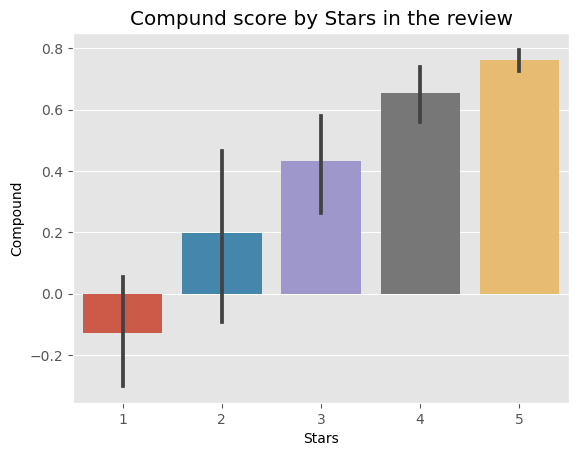

In [18]:
ax = sns.barplot(data=vaders,x="Score",y="compound")
ax.set_title("Compund score by Stars in the review")
ax.set_xlabel("Stars")
ax.set_ylabel("Compound");

### But lets look at the actual postive,neutral scores side by side rather than a compound score

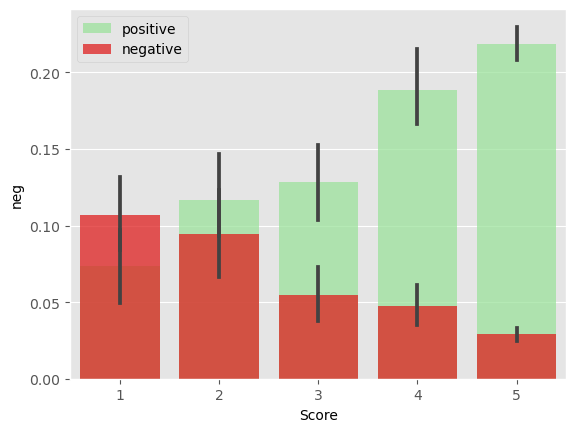

In [19]:
ax = sns.barplot(data=vaders,x="Score",y="pos",alpha=0.75,color="lightgreen",label="positive")
sns.barplot(data=vaders,x="Score",y="neg",color="red",alpha=0.75,label="negative",ax=ax)
ax.legend();

- Clearly we see that the more stars the review has the more postive the sentiment is

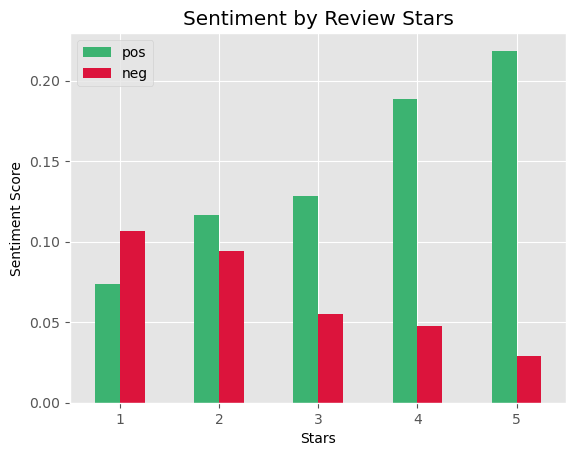

In [20]:
ax = vaders.groupby("Score").agg({"pos":"mean","neg":"mean"}).plot(kind="bar",
                                                             color=["mediumseagreen","crimson"],
                                                                   title="Sentiment by Review Stars")

ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
ax.set_xlabel("Stars")
ax.set_ylabel("Sentiment Score");

- Another way to look at it

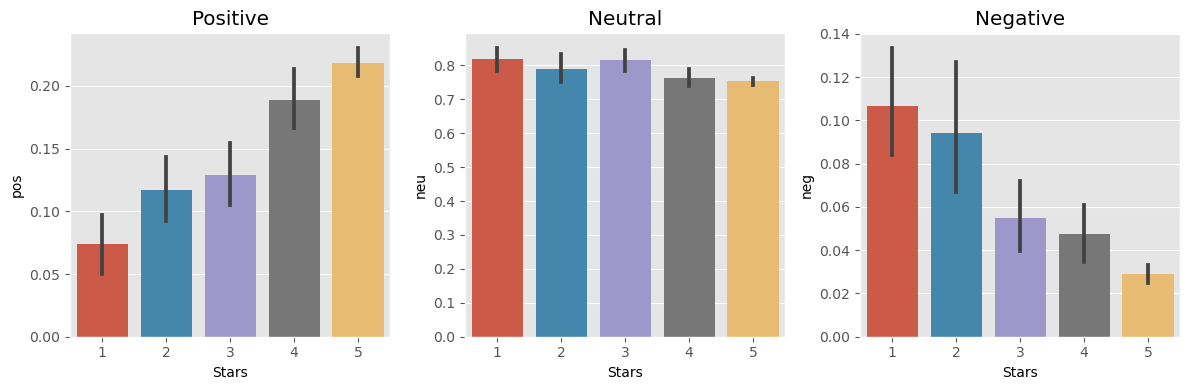

In [51]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
sns.barplot(data=vaders,x="Score",y="pos",ax=axes[0])
sns.barplot(data=vaders,x="Score",y="neu",ax=axes[1])
sns.barplot(data=vaders,x="Score",y="neg",ax=axes[2]) 
axes[0].set_title("Positive")
axes[0].set_xlabel("Stars")
axes[1].set_title("Neutral")
axes[1].set_xlabel("Stars")
axes[2].set_title("Negative")
axes[2].set_xlabel("Stars")
plt.tight_layout();

- This way also includes Neutral scores

### Seems like our VADER (Valence Aware Dictionary and sEntiment Reasoner) model performed raltively well using its bag of words approach. However it doesn't account for relationship between words, which can really affect the sentiment of a sentence. This is where the RoBERTa Model comes in which uses Deep Learning. The RoBERTa model can actually understand relationships between words and therefore can better predict the sentiment of a sentence.

In [22]:
from transformers import AutoTokenizer # break down the sentence into words
from transformers import AutoModelForSequenceClassification # actually classify the words
from scipy.special import softmax

#### We will use a larger pretrained model that actually is trained on sentiment from tweets this will allow us to be even more accurate with our sentiment analysis

In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL) # tokenizes based on pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

### Lets do a direct comparison using the example we had been using but now we will see what RoBERTa thinks about it

- Text: My husband is a Twizzlers addict.  We've bought these many times from Amazon because we're government employees living overseas and can't get them in the country we are assigned to.  They've always been fresh and tasty, packed well and arrive in a timely manner.

In [24]:
encoded = tokenizer(example,return_tensors="pt") # the text becomes encoded for it to be machine readable
output = model(**encoded) # use our model to interpret the tokenized text now that was encoded
scores = output[0][0].detach().numpy() # are socres that our model predicted
scores = softmax(scores) # to make them in between 0 and 1 for interpretability
scores_dict = {"neg":scores[0],
               "neu":scores[1],
               "pos":scores[2],}
print("What Roberta Says:", scores_dict,"\n")
print("What VADER Says:", sia.polarity_scores(example),"\n")

What Roberta Says: {'neg': 0.010422168, 'neu': 0.06525921, 'pos': 0.9243186} 

What VADER Says: {'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.6249} 



### RoBERTa is way more confident that the text is positive compared to VADER. Lets make a function so the entire RoBERTa step can be done without writing all the above code

In [25]:
def polarity_scores_roberta(example):
    encoded = tokenizer(example,return_tensors="pt")
    output = model(**encoded) 
    scores = output[0][0].detach().numpy() 
    scores = softmax(scores) 
    scores_dict = {"roberta_neg":scores[0],
                   "roberta_neu":scores[1],
                   "roberta_pos":scores[2]}
    return scores_dict

In [26]:
res = {}

for i,row in tqdm(df.iterrows(),total=len(df)):
    try:
        cur_id = row["Id"]
        cur_text = row["Text"]
        pre_vader_score = sia.polarity_scores(cur_text)
        vader_score = {}
        for key,value in pre_vader_score.items():
            new_key = f"vader_{key}"
            vader_score[new_key] = value

        roberta_score = polarity_scores_roberta(cur_text)
        both = {**vader_score,**roberta_score} # a way to combine to dicts together into one dict
        res[cur_id] = both
        
    except RuntimeError:
        print(f"The text was to large at Id:{cur_id}")

  0%|          | 0/500 [00:00<?, ?it/s]

The text was to large at Id:83
The text was to large at Id:187


### Lets merge these results of RoBERTa and vader back to the original dataframe

In [27]:
results = pd.DataFrame(res).T.reset_index().rename(columns={"index":"Id"})# we want to flip the rows and columns so that each row rperesnts an ID
df = results.merge(df,how="left")
df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940396,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Lets make a pair plot so we can see how Vader stands up to RoBERTa

In [28]:
df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

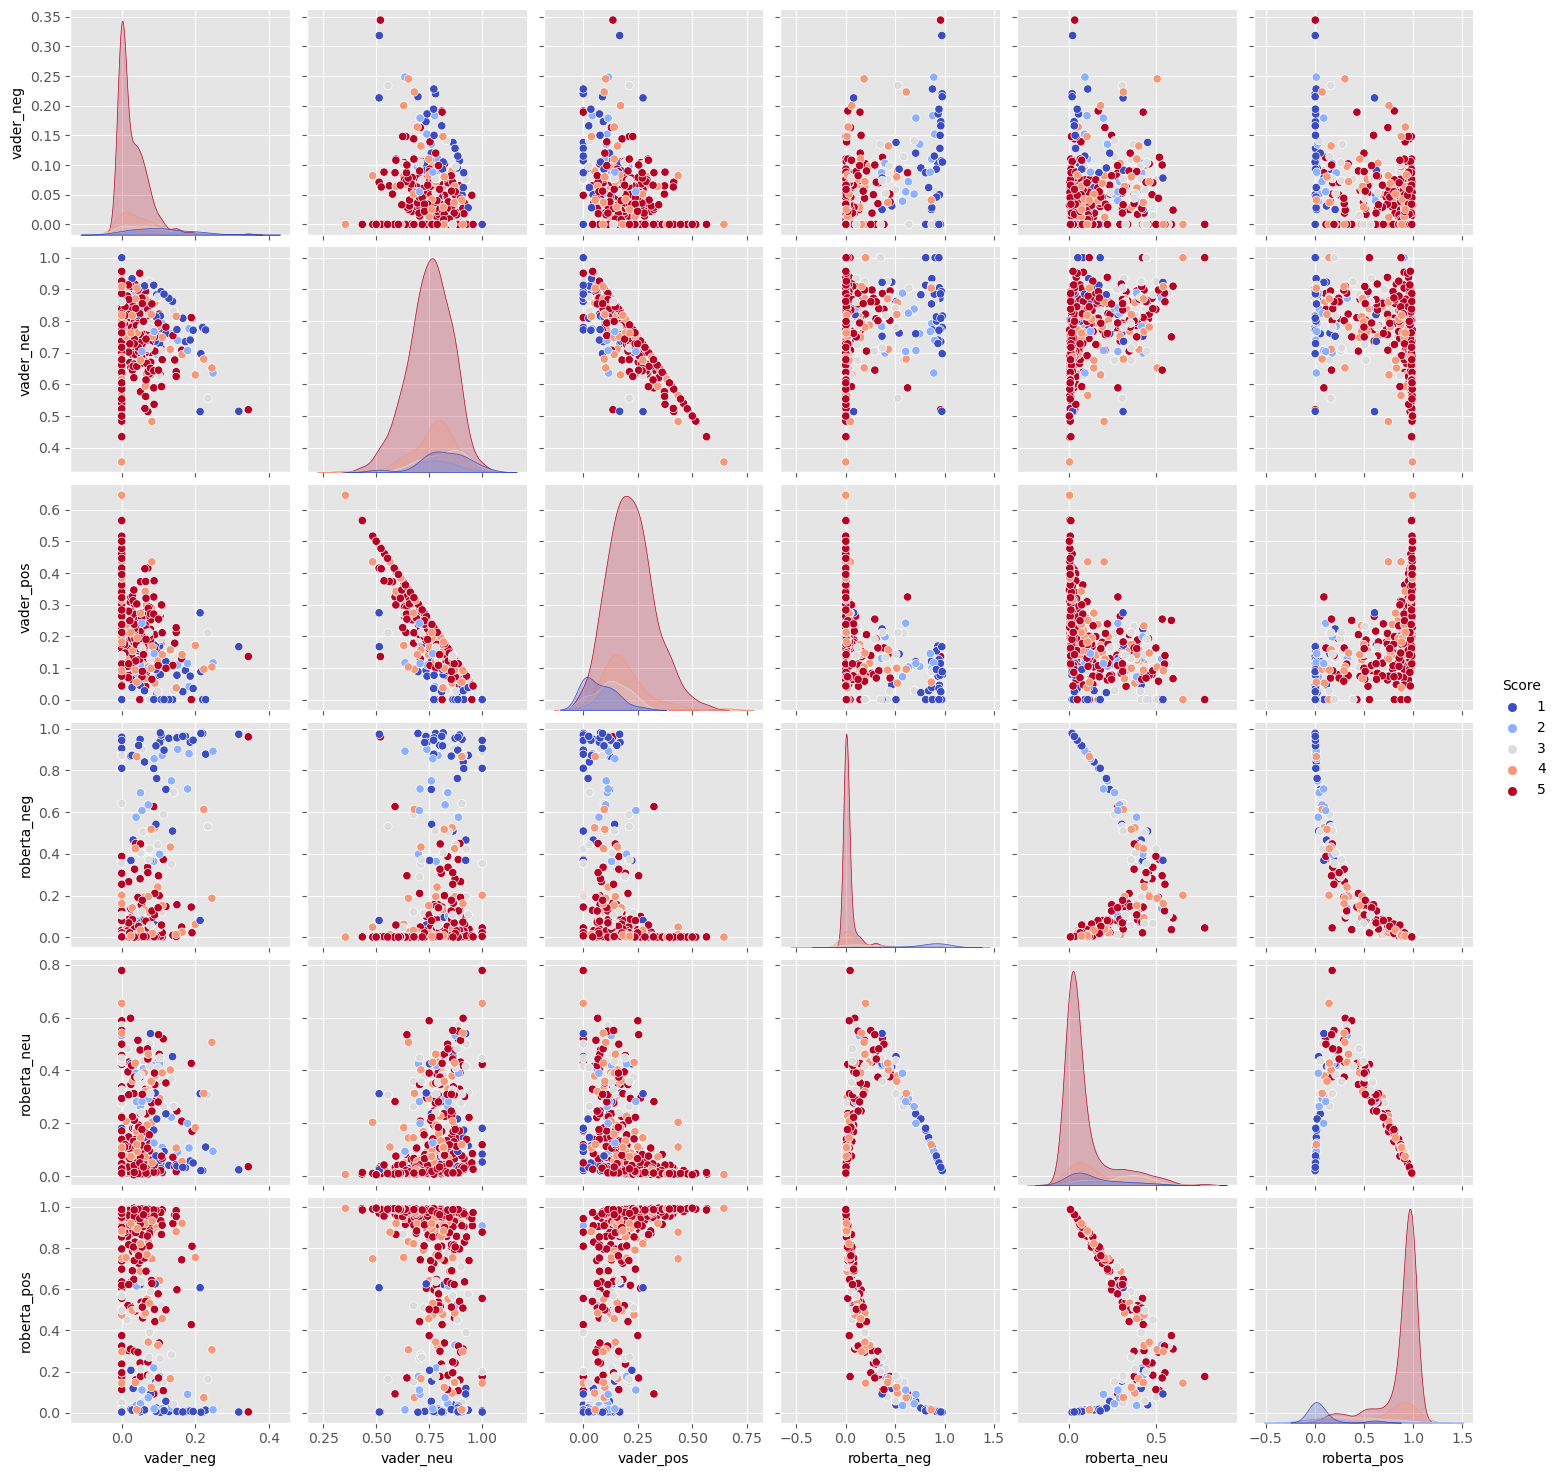

In [29]:
sns.pairplot(data=df,
             vars=['vader_neg', 'vader_neu', 'vader_pos','roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue="Score",
            palette="coolwarm");

### This may be hard to interpret but just look at the density plots not the one with points but the ones that look like waves. Notice that the RoBERTa density plots are much tighter because RoBERTa is more confidence in it's analysis while Vader's density plots are wide because it is more uncertain with it's analysis.

### Now lets look at some examples where the models may break down. Lets first check where the review has a 1 star review but the model thought of the review as positive with high certainty

#### The query below is checking where the review was one star but RoBERTa still thought of it as a positive review with a high certainty
- This one was definitely tricky because even though it start out positive it ends with a negative sentiment which in turn makes the entire review negative. Also it is 1 star so that is a giveaway but RoBERTa doesn't know that

In [30]:
df.query("Score==1").sort_values(by="roberta_pos",ascending=False).loc[252,"Text"]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

#### The query below checks for a 1 star review which Vader though was a positive review with high certainty
- Vader though this was a positive review probably because the review contains the word positive. However, because Vader doesn't pickup the relationship between words like RoBERTa it didn't pick up on the fact that the order was canceled and therefore was a negative review with the "positive note" being sarcastic

In [31]:
df.query("Score==1").sort_values(by="vader_pos",ascending=False).loc[322,"Text"]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

### Lets check the opposite now. The review has a 5 star review yet the model still though of it as negative with a high certainty

#### The query below checks for a 5 star review which RoBERTa though was a Negative review with high certainty
- RoBERTa probably thought of this a negative review because the gaining of weight combined with words like too bad and my fault.

In [32]:
df.query("Score==5").sort_values(by="roberta_neg",ascending=False).loc[69,"Text"]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

#### The query below checks for a 5 star review which Vader though was a Negative review with high certainty
- Just like RoBERTa Vader probably had too many negative words in the bag of words feature which made it think the review was negative

In [33]:
df.query("Score==5").sort_values(by="vader_neg",ascending=False).loc[69,"Text"]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

### So both RoBERTa and Vader perform relatively well for sentiment Analysis but it does seem like RoBERTa has a slight edge. However we had to do a bit of work to make this all possible. Luckily hugging face has a Machine Learning pipeline built literally for sentiment analysis

In [34]:
from transformers import pipeline

sentiment_pipe = pipeline(task="sentiment-analysis")
example

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


"My husband is a Twizzlers addict.  We've bought these many times from Amazon because we're government employees living overseas and can't get them in the country we are assigned to.  They've always been fresh and tasty, packed well and arrive in a timely manner."

### lets try our new pipeline for sentiment-analysis on the example text you can see above
- The output is slightly different but you can see that it was able to identify that the review was positive with a really high score 

In [35]:
sentiment_pipe(example) 

[{'label': 'POSITIVE', 'score': 0.9998146891593933}]

## Now lets use our pipeline for all the reviews and then add what the pipeline thinks to the dataframe

In [36]:
pipe_dict = {}
for i,row in tqdm(df.iterrows(),total=len(df)):
    cur_id = row["Id"]    
    try:
        cur_text = row["Text"]
        pipe_dict[cur_id] = sentiment_pipe(cur_text)[0]
        
    except RuntimeError:
        print(f"The text was to large at Id:{cur_id}")

  0%|          | 0/498 [00:00<?, ?it/s]

In [37]:
pipe_df = pd.DataFrame(pipe_dict).T.reset_index()
pipe_df = pipe_df.rename(columns={"index":"Id","label":"Pipe_label","score":"Pipe_score"})
df = pipe_df.merge(df,how="left",on="Id")

## Look at how the pipe score agrees with the Vader and RoBERTa model but is just much more confident

In [38]:
df.head()

,Id,Pipe_label,Pipe_score,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,POSITIVE,0.998385,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940396,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,NEGATIVE,0.999525,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,POSITIVE,0.999765,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,POSITIVE,0.999153,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,POSITIVE,0.998708,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [39]:
ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
pipe_label_ohe = ohe.fit_transform(df[["Pipe_label"]])
df = pd.concat([pipe_label_ohe,df],axis=1)

## You see for each given star review the proportion of negative and positive are very accurate. There are a few mistakes but those are probably reviews that are extremely hard to interpret

In [48]:
pipe_plot = df.groupby("Score")[["Pipe_label_NEGATIVE","Pipe_label_POSITIVE"]].mean()
pipe_plot

,Pipe_label_NEGATIVE,Pipe_label_POSITIVE
Score,,
1,0.972222,0.027778
2,0.722222,0.277778
3,0.702703,0.297297
4,0.342857,0.657143
5,0.139466,0.860534


## To wrap up lets  graph out the proportions for each star
- There is clearly a tend where the positive sentiment increases as you get more stars and the opposite is true as you get less stars

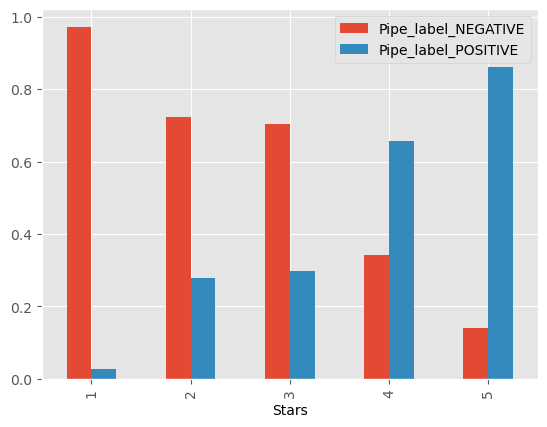

In [67]:
ax = pipe_plot.plot(kind="bar")
ax.set_xlabel("Stars");